## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions


In [1]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
#reading the data and converting the Date column into pandas datetime object and also making it the index
df = pd.read_csv('/mnt/wanyao/hhf/mbrl/dataset/China_SSE_20210101-12h19.csv')
data = df[df['tic']=='600000.SS']
data = data[['date','open','high','low','close','volume']]
print(data)

data.index = data['date']
data.drop(['date'], axis = 1, inplace = True)
data.index = pd.to_datetime(data.index)

              date      open      high       low     close       volume
0       2000-01-04  2.912484  3.005759  2.885668  1.814433   38562183.0
4       2000-01-05  2.981274  3.029077  2.932305  1.793855   45052693.0
8       2000-01-06  2.935803  3.066387  2.920646  1.844237   53430896.0
12      2000-01-07  3.066387  3.206298  3.045400  1.908809  183161852.0
16      2000-01-10  3.148002  3.247105  3.114190  1.933645  141859094.0
...            ...       ...       ...       ...       ...          ...
105888  2020-12-25  9.560000  9.610000  9.510000  9.119699   22420976.0
105918  2020-12-28  9.550000  9.630000  9.500000  9.110180   33765935.0
105948  2020-12-29  9.600000  9.620000  9.520000  9.072103   44150648.0
105978  2020-12-30  9.520000  9.540000  9.440000  9.043544   54885564.0
106008  2020-12-31  9.510000  9.690000  9.490000  9.214895   65992362.0

[4977 rows x 6 columns]


/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data

,open,high,low,close,volume
date,,,,,
2000-01-04,2.912484,3.005759,2.885668,1.814433,38562183.0
2000-01-05,2.981274,3.029077,2.932305,1.793855,45052693.0
2000-01-06,2.935803,3.066387,2.920646,1.844237,53430896.0
2000-01-07,3.066387,3.206298,3.045400,1.908809,183161852.0
2000-01-10,3.148002,3.247105,3.114190,1.933645,141859094.0
...,...,...,...,...,...
2020-12-25,9.560000,9.610000,9.510000,9.119699,22420976.0
2020-12-28,9.550000,9.630000,9.500000,9.110180,33765935.0
2020-12-29,9.600000,9.620000,9.520000,9.072103,44150648.0


In [5]:
data.isnull().sum() #checking if there are any null or infinite values

open      0
high      0
low       0
close     0
volume    0
dtype: int64

# Visualizing the Data

In [6]:
data.drop([ 'open' , 'high', 'low', 'volume'], axis = 1, inplace = True)

In [7]:
data

,close
date,
2000-01-04,1.814433
2000-01-05,1.793855
2000-01-06,1.844237
2000-01-07,1.908809
2000-01-10,1.933645
...,...
2020-12-25,9.119699
2020-12-28,9.110180
2020-12-29,9.072103


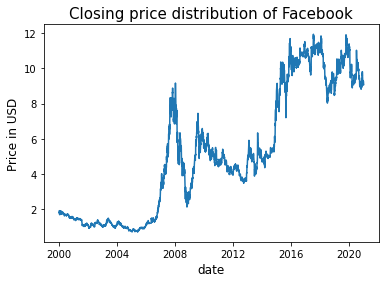

In [8]:
plot.plot(data['close'])
plot.xlabel('date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title("Closing price distribution of Facebook", fontsize=15)
plot.show()

In [9]:
df = data['close']

# Resampling to daily frequency
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

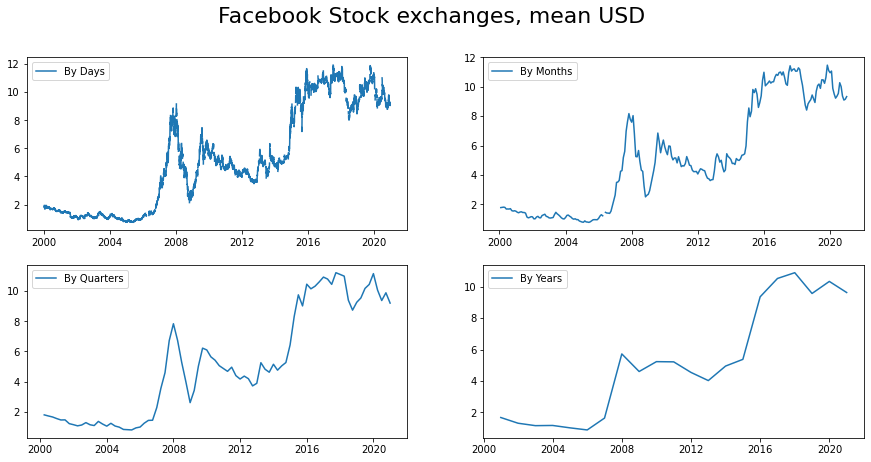

In [10]:
# PLOTS
fig = plot.figure(figsize=[15, 7])
plot.suptitle('Facebook Stock exchanges, mean USD', fontsize=22)

plot.subplot(221)
plot.plot(df, '-', label='By Days')
plot.legend()

plot.subplot(222)
plot.plot(df_month, '-', label='By Months')
plot.legend()

plot.subplot(223)
plot.plot(df_Q, '-', label='By Quarters')
plot.legend()

plot.subplot(224)
plot.plot(df_year, '-', label='By Years')
plot.legend()

# plt.tight_layout()
plot.show()

# Checking Stationarity of the data

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=22,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationary")
            break
         else:
            print("The graph is stationary")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

In [12]:
df = df.fillna(method='ffill')

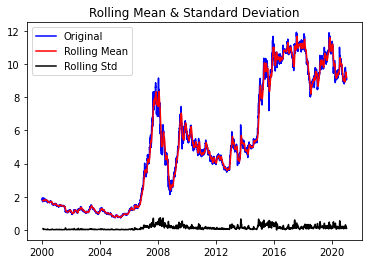

ADF Stastistic: -1.097886
p-value: 0.715914
The graph is non stationary
Critical values:
	1%: -3.431 
	5%: -2.862 
	10%: -2.567 


In [13]:
test_stationarity(df)

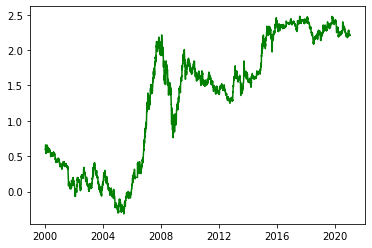

In [14]:
ts_log = np.log(data['close'])
plot.plot(ts_log,color="green")
plot.show()

In [15]:
data['Log transformed'] = ts_log 

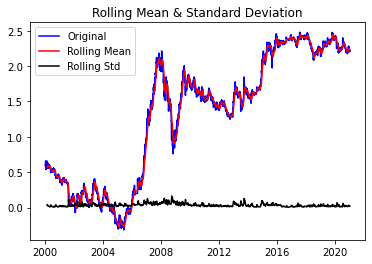

ADF Stastistic: -0.725642
p-value: 0.839996
The graph is non stationary
Critical values:
	1%: -3.432 
	5%: -2.862 
	10%: -2.567 


In [16]:
test_stationarity(data['Log transformed'])

In [17]:
#[1 2 3 4 5 6 7 8 9 10] - [NaN 1 2 3 4 5 6 7 8 9] = [Nan ...]

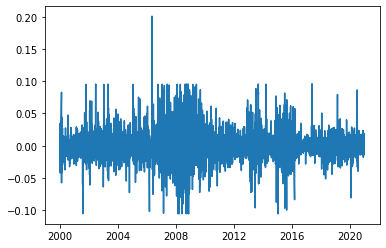

In [18]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

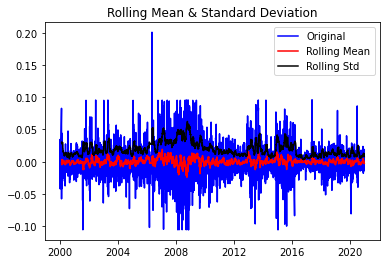

ADF Stastistic: -31.513916
p-value: 0.000000
The graph is stationary
Critical values:
	1%: -3.432 
	5%: -2.862 
	10%: -2.567 


In [19]:
test_stationarity(ts_log_diff.dropna())

In [20]:
data['Shifted Log transformed'] = ts_log_diff

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

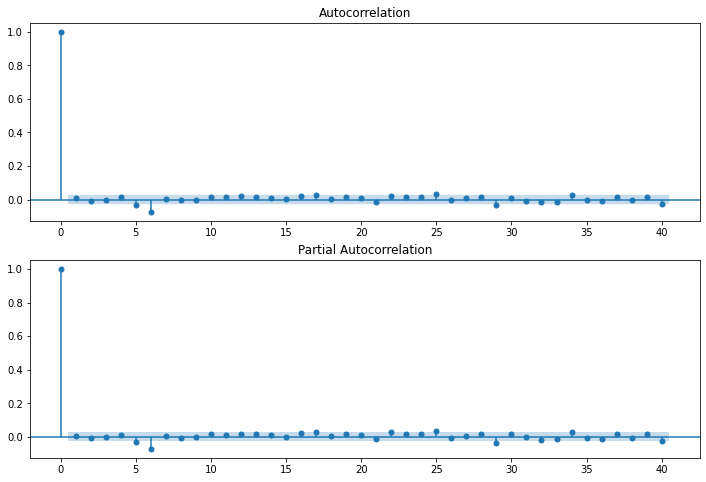

In [22]:
fig = plot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Shifted Log transformed'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Shifted Log transformed'].dropna(),lags=40,ax=ax2)

# Making Predictions

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
size = int(len(ts_log)-1000)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value.
# We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

Printing Predicted vs Expected Values...




/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted = 10.978362,   expected = 11.137739,   error = 1.430961  %
predicted = 11.144111,   expected = 11.111423,   error = 0.294189  %
predicted = 11.115859,   expected = 11.242998,   error = 1.130827  %
predicted = 11.249377,   expected = 11.321942,   error = 0.640929  %
predicted = 11.327407,   expected = 11.354836,   error = 0.241555  %
predicted = 11.360222,   expected = 11.289048,   error = 0.630468  %
predicted = 11.293604,   expected = 11.282471,   error = 0.098682  %
predicted = 11.287780,   expected = 11.249577,   error = 0.339598  %
predicted = 11.254393,   expected = 11.381151,   error = 1.113757  %
predicted = 11.387539,   expected = 11.328520,   error = 0.520975  %
predicted = 11.332929,   expected = 11.229840,   error = 0.917993  %
predicted = 11.234352,   expected = 11.275892,   error = 0.368403  %
predicted = 11.281574,   expected = 11.400887,   error = 1.046525  %
predicted = 11.406984,   expected = 11.506147,   error = 0.861831  %
predicted = 11.512061,   expected 

/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/mnt/wanyao/hhf/gymenv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted = 10.971579,   expected = 10.999587,   error = 0.254626  %
predicted = 11.004745,   expected = 11.039058,   error = 0.310830  %
predicted = 11.044224,   expected = 11.085111,   error = 0.368841  %
predicted = 11.090367,   expected = 11.019321,   error = 0.644738  %
predicted = 11.023599,   expected = 11.078530,   error = 0.495837  %
predicted = 11.084135,   expected = 11.039058,   error = 0.408341  %
predicted = 11.043462,   expected = 10.946958,   error = 0.881567  %
predicted = 10.951197,   expected = 11.124582,   error = 1.558576  %
predicted = 11.131185,   expected = 11.104845,   error = 0.237191  %
predicted = 11.109177,   expected = 11.019321,   error = 0.815440  %
predicted = 11.023699,   expected = 10.979850,   error = 0.399364  %
predicted = 10.984542,   expected = 10.993007,   error = 0.077005  %
predicted = 10.998038,   expected = 10.914063,   error = 0.769424  %
predicted = 10.918195,   expected = 10.914063,   error = 0.037865  %
predicted = 10.919075,   expected 